# Fitting a 3PL model using numpyro

For information about the 3PL model, see [this](https://en.wikipedia.org/wiki/Item_response_theory).

The model can be fitted using R as in [`nplmodel`](https://search.r-project.org/CRAN/refmans/psychotools/html/nplmodel.html). There, however, ML estimation is used. 

Here, a Bayesian alternative will be provided. Data from the R dataset `psychotools::MathExam14W` will be used in what follows.

In [74]:
import pandas as pd
import numpy as np

import jax
import jax.numpy as jnp

import numpyro
from numpyro.distributions import Normal, Beta, HalfNormal, Bernoulli
from numpyro.infer import MCMC, NUTS

#import arviz as az

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)

## Import data

The data contains scores (0/1) for 13 exam questions and 729 students.

In [75]:
data = pd.read_csv("math_exam.csv")
data.head()

,quad,deriv,elasticity,integral,interest,annuity,payflow,matrix,planning,equations,hesse,implicit,lagrange
0,1,1,1,0,1,1,0,1,1,0,1,1,0
1,1,1,1,1,0,0,0,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0,1,0,0,1,0,1,1,0,0,1,0
4,0,1,0,1,1,1,1,1,1,1,1,1,1


## Model

The model provides the probability that student $i$ with _ability_ $\theta_i$ answers question $j$ correctly using the following formula:

$$p_i(\theta) = g_j + \frac{1 - g_j}{1 + \exp(-d_j(\theta_i - b_j)) }$$

where:

- $g_j$ is the probability of getting the answer correctly by guessing
- $b_j$ is the difficulty of the question (that subtracts from the student ability)
- $d_j$ is the discriminatory power of the question, i.e., how well it discriminates according to the _net ability_.

The model can be programmed in `numpyro` as follows:

In [76]:
def model3pl(scores, n_students, n_questions):
    with numpyro.plate("students", n_students):
        ability = numpyro.sample("ability", Normal(0, 1))

    with numpyro.plate("questions", n_questions):
        guessing = numpyro.sample("guessing", Beta(1, 1))
        discrimination = numpyro.sample("discrimination", HalfNormal(1))     
        difficulty = numpyro.sample("difficulty", Normal(0, 1))     

    probs = ability[:, np.newaxis] - difficulty
    probs = jnp.exp(-discrimination * probs)
    probs = guessing + (1 - guessing) / (1 + probs)
  
    probs = jnp.reshape(jnp.array(probs), (-1))

    return numpyro.sample("scores", Bernoulli(probs), obs = scores)



Now we can fit it:

In [77]:
rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_ = jax.random.split(rng_key)

# Run NUTS.
kernel = NUTS(model3pl)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)

my_data = data.iloc[:, :]

mcmc.run(
    rng_key_, 
    scores = np.reshape(my_data.to_numpy(), (-1)),
    n_students = my_data.shape[0],
    n_questions = my_data.shape[1])


sample: 100%|██████████| 3000/3000 [00:33<00:00, 89.93it/s, 31 steps of size 1.00e-01. acc. prob=0.92] 


## Analysis of the results

Here we show a number of graphics summarizing the results, i.e., the posterior distributions of the parameters.

In [78]:
samples = mcmc.get_samples()   

In [79]:
def violin(tmp):
    tmp = [tmp[:, i] for i in range(tmp.shape[1])]

    means = [np.mean(x) for x in tmp]
    order = np.argsort(means)
    tmp = [tmp[i] for i in order]
    labels = [data.columns[i] for i in order]

    # Sort the data and means in descending order
    # sorted_data = tmp #[d for _, d in sorted(zip(means, tmp), reverse=True)]
    # sorted_means = sorted(means, reverse=True)

    fig, ax = plt.subplots()
    ax.violinplot(tmp, positions = range(len(tmp)),
                  showmeans=True, showextrema=False, showmedians=False,
                  vert = False)

    # Set the x-tick labels based on the sorted means
    ax.set_yticks(np.arange(0, len(labels)))
    ax.set_yticklabels(labels)

    plt.show()        

### Guessing probabilities

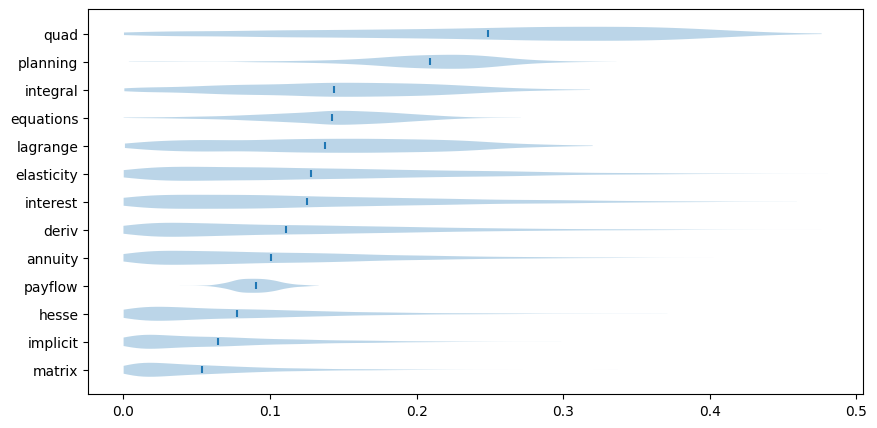

In [80]:
violin(samples['guessing'])

### Question difficulty

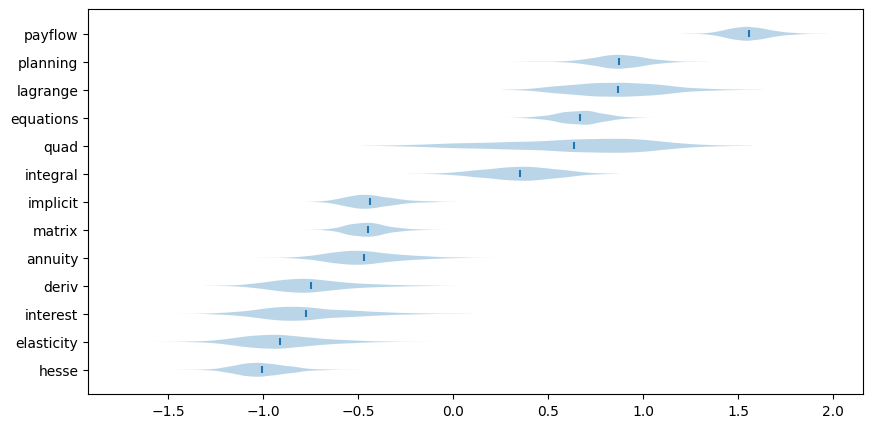

In [81]:
violin(samples['difficulty'])

### Question discrimination

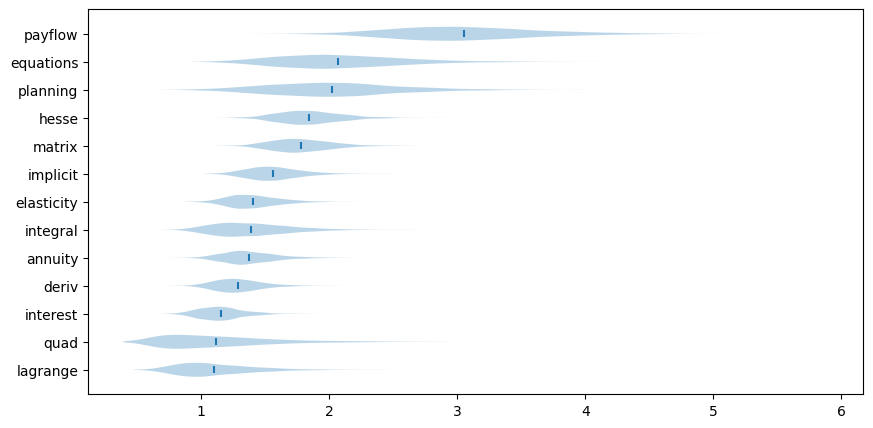

In [82]:
violin(samples['discrimination'])

### Students ability

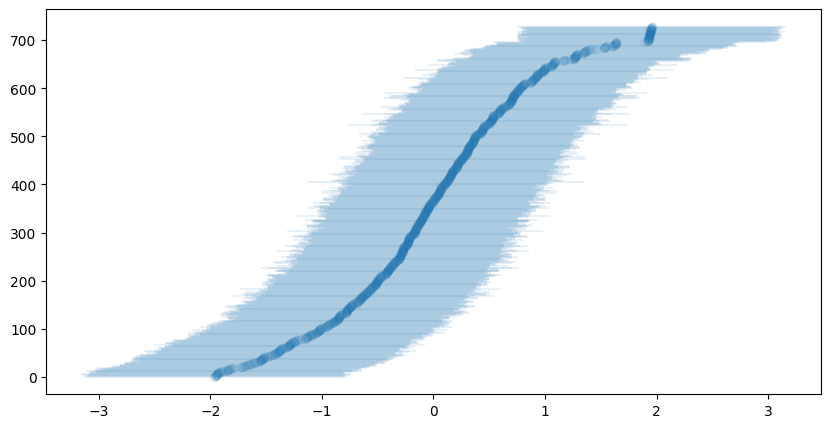

In [83]:
tmp = [samples['ability'][:,i] for i in range(samples['ability'].shape[1])]
order = np.argsort([np.mean(x) for x in tmp])
tmp = [tmp[i] for i in order]
tmp_means = [np.mean(x) for x in tmp]
tmp_errors = [2 * np.std(x) for x in tmp]

tmp_x = range(len(tmp))

fig, ax = plt.subplots()
ax.errorbar(tmp_means, tmp_x, xerr = tmp_errors, fmt = 'o', alpha = .1);
